# Sorting lines in each box with PubLayNet boxes

In [1]:
!ls ../../edspdf-train/data/publaynet/

dev.json xmls     xmls.zip


In [2]:
dir = '../../edspdf-train/data/publaynet/'

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.executable

'/Users/souleymbaye/opt/anaconda3/envs/eds_env/bin/python'

In [4]:
import edspdf
from edspdf import Pipeline
from edspdf.visualization.annotations import show_annotations
from edspdf.visualization import merge_boxes
# import datasets
from edspdf.utils.lines_partition import partition_lines_in_boxes
from edspdf.utils.alignment import align_box_labels
from typing import Any, Callable, Generator, Iterable, List, Optional, Union
from edspdf.registry import registry
from edspdf.structures import Box, PDFDoc
from edspdf.structures import TextBox

from pathlib import Path
import json

import os
import numpy as np

In [5]:
model = edspdf.Pipeline()
model.add_pipe("mupdf-extractor", config={"sort_mode": "lines"}, name="extractor")

In [6]:
@registry.adapter.register("segmentation-adapter")
def make_segmentation_adapter(
    dev_path: str = '../../edspdf-train/data/publaynet/dev.json',
    xmls_dir: str = '../../edspdf-train/data/publaynet/xmls/',
    all_pdfs: bool = False
) -> Callable[[Pipeline], Generator[PDFDoc, Any, None]]:
  def adapt(model):
    with open(Path(dev_path)) as f:
      samples = json.load(f)
    
    # load xml files
    xmls_names = {} # {pmc = {xml_fname, pdf_fname}}
    for root, directories, files in os.walk(xmls_dir):
      for pmc in directories:
        fdir = xmls_dir + pmc
        for root2, directories2, files2 in os.walk(fdir):
          xml_fname = None
          pdfs_fnames = []
          for file in files2:
            if file.split('.')[-1] == 'nxml':
              xml_fname = file
            if file.split('.')[-1] == 'pdf':
              pdfs_fnames.append(file)
          
          lenghts = [len(pf) for pf in pdfs_fnames]
          # if len(lenghts) == 0:
          #   print(f'fdir ==> {fdir}')
          
          i_min = np.argmin(lenghts)
          xmls_names[pmc] = {'xml' :xml_fname, 'pdf': pdfs_fnames[i_min]}
      break
    # end load xml files
    
    
    if not all_pdfs: # only images in xmls_names
        samples_img = [
          sample_img
          for sample_img in samples['images']
          if sample_img['file_name'].split('_')[0] in xmls_names
        ]
        samples['images'] = samples_img
    # end only images in xmls_names


    # Index images
    images = {}
    for image in samples['images']:
        images[image['id']] = {
        'pmc_id': image['file_name'].split('_')[0], 
        'page_num': int(image['file_name'].split('_')[1].split('.')[0]), 
        'annotations': []
        }
    for ann in samples['annotations']:
        if all_pdfs:
            images[ann['image_id']]['annotations'].append(ann) # all
        elif ann['image_id'] in images: # with only images in xmls_names
            images[ann['image_id']]['annotations'].append(ann)
    # end index images
    
    
    for  sample in samples['images']:
      # if images[sample['id']]['pmc_id'] not in xmls_names:
      #   continue
      
      # print('pmc id:', images[sample['id']]['pmc_id'], 'xml ==> ',xmls_names[images[sample['id']]['pmc_id']])
      # print('image ==> ',images[sample['id']])

      # boxes from PubLN
      w, h = sample['width'], sample['height']
      boxes = [
        TextBox(
          x0=annotation["bbox"][0]/w,
          y0=annotation["bbox"][1]/h,
          x1=annotation["bbox"][0]/w + annotation["bbox"][2]/w,
          y1=annotation["bbox"][1]/h + annotation["bbox"][3]/h,
          page_num=images[sample['id']]['page_num'],
          label=annotation["category_id"],
          text='CLS'
        ).dict()
        for annotation in images[sample['id']]['annotations']
      ]


      # tboxes from PdfMiner
      pmc_id = images[sample['id']]['pmc_id']
      xml_name = xmls_names[pmc_id]
      xml_path = xmls_dir + pmc_id + '/' + xml_name['xml']
      pdf_path = xmls_dir + pmc_id + '/' + xml_name['pdf']

      sample_content = Path(pdf_path).read_bytes()
      doc: PDFDoc = model.get_pipe("extractor")(sample_content) # doc = model(doc)
      doc.content_lines = doc.content_boxes
      doc._page_num = images[sample['id']]['page_num']
      
      # debug
      doc.boxes = [TextBox(**tb) for tb in boxes]
      # doc.annots = [ann for annotation in images[sample['id']]['annotations']]
      # doc.pdf_path = pdf_path
      # doc.cbx = doc.content_boxes
      
      # Merging src_boxes(tboxes_k from PubLN) with lines(pdf.content from PdfMiner)
      doc.content_boxes = [
        line
        for line in align_box_labels(
          src_boxes=[
            Box(
              page_num= tboxe['page_num'],
              x0= tboxe['x0'],
              x1= tboxe['x1'],
              y0= tboxe['y0'],
              y1= tboxe['y1'],
              label= samples['categories'][tboxe['label']-1]['name']
            )
            for tboxe in boxes
          ],
          dst_boxes=doc.content_boxes,
          pollution_label='pollution',
        )
        if line.text == "" or line.label is not None
      ]
      
      # for each box the list of contained lines
      doc.boxes_lines = [
        box_lines
        for box_lines in partition_lines_in_boxes(
          src_boxes=[
            Box(
              page_num= tboxe['page_num'],
              x0= tboxe['x0'],
              x1= tboxe['x1'],
              y0= tboxe['y0'],
              y1= tboxe['y1'],
              label= samples['categories'][tboxe['label']-1]['name']
            )
            for tboxe in boxes
          ],
          dst_boxes=doc.content_boxes,
          pollution_label='pollution',
        )
        # if box_lines.text == "" or box_lines.label is not None
      ]
    
      yield doc

  return adapt

## Visualization

In [7]:
from tqdm import tqdm

In [8]:
dev_path: str = dir + 'dev.json'
xmls_dir: str = dir + 'xmls/'

k = 0
for doc in tqdm(make_segmentation_adapter(dev_path=dev_path, xmls_dir=xmls_dir)(model), mininterval=1):
  k -= 1
  
  if k < 0:
    break

  pass

# print(doc.content_boxes)

0it [00:01, ?it/s]


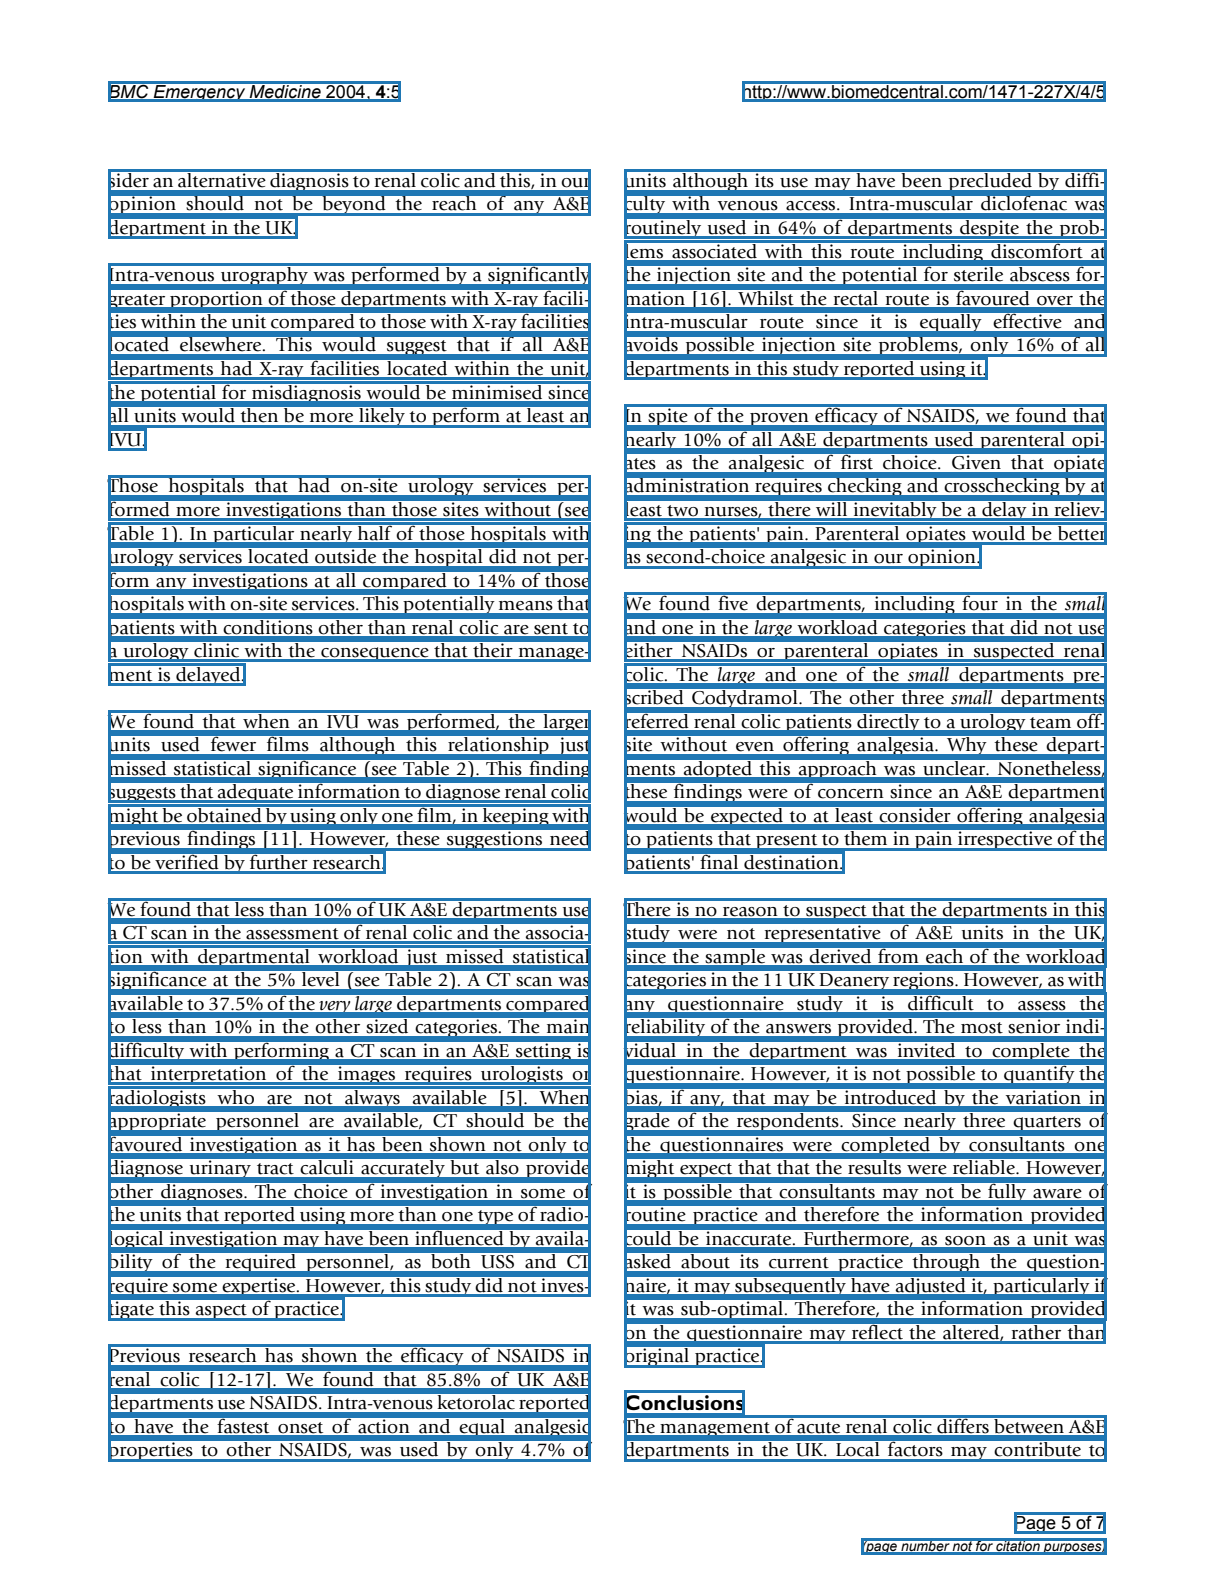

In [9]:
pages = [page for page in show_annotations(doc.content, doc.content_lines)]
display(pages[doc._page_num])

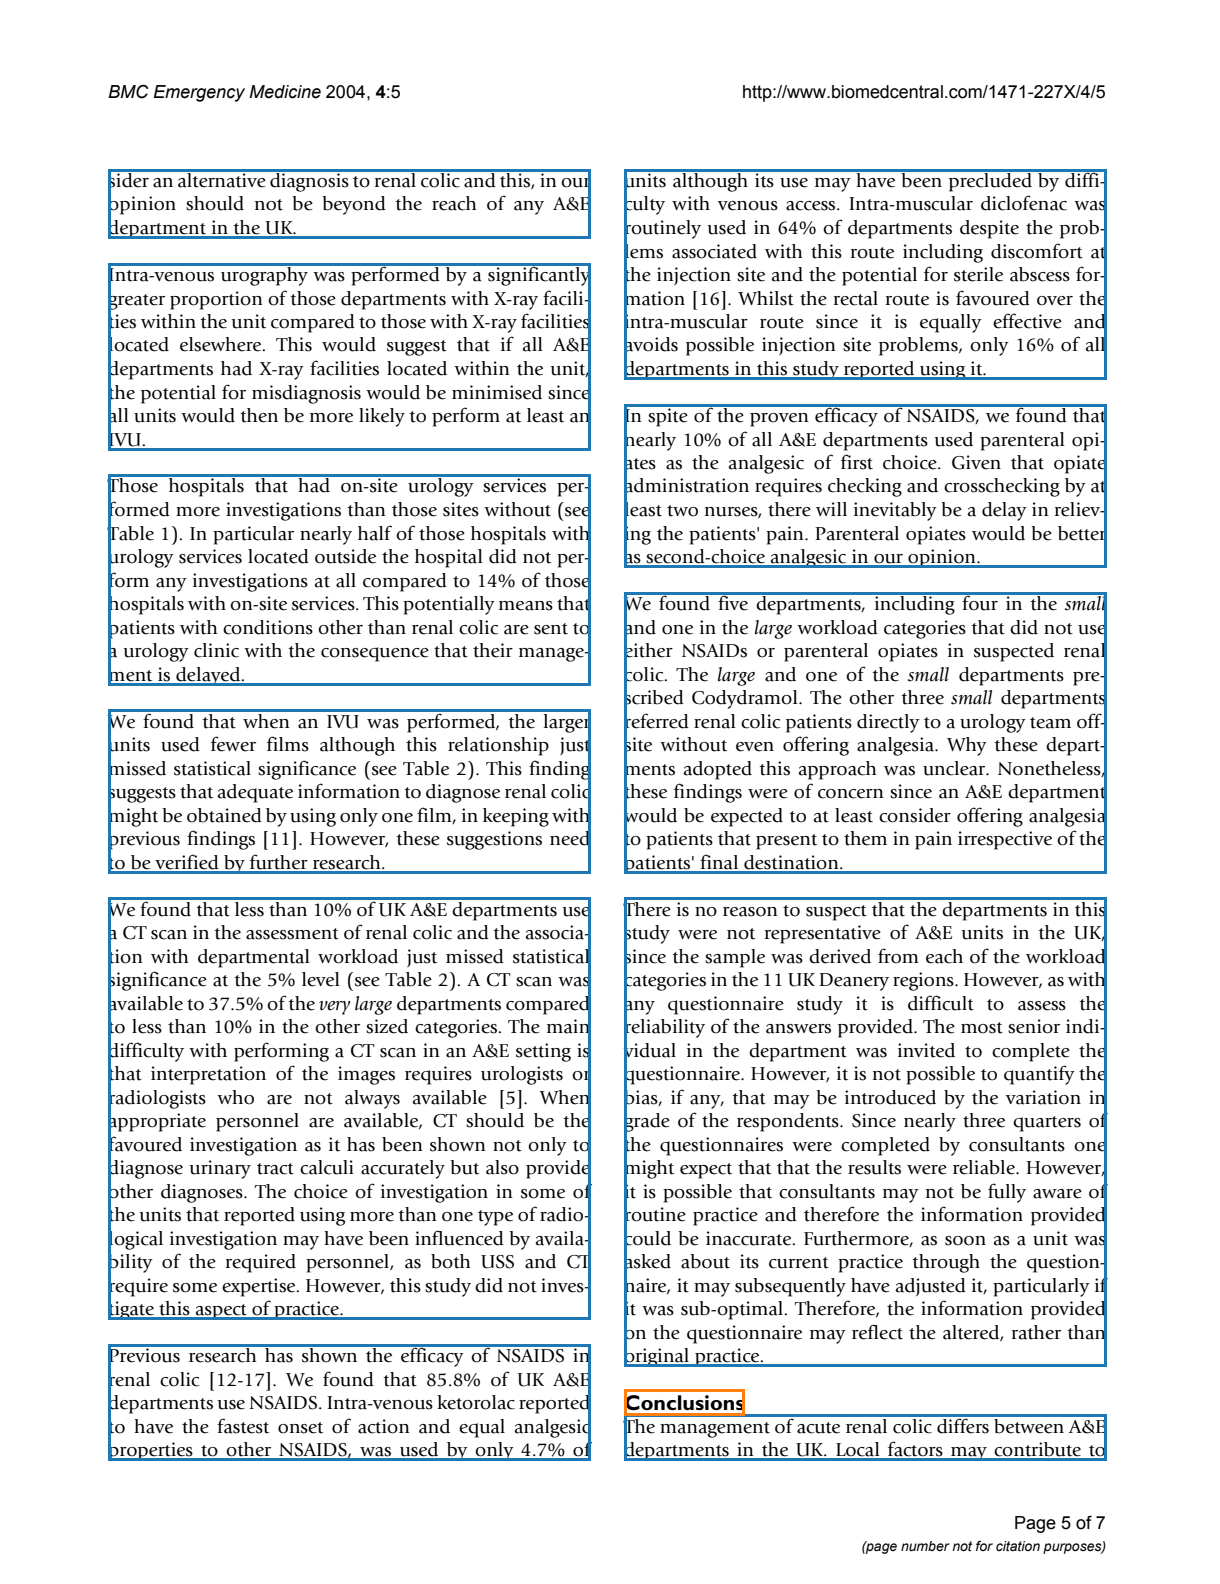

In [10]:
# boxes from PubLayNet
pages = [page for page in show_annotations(doc.content, doc.boxes)]
display(pages[doc._page_num])

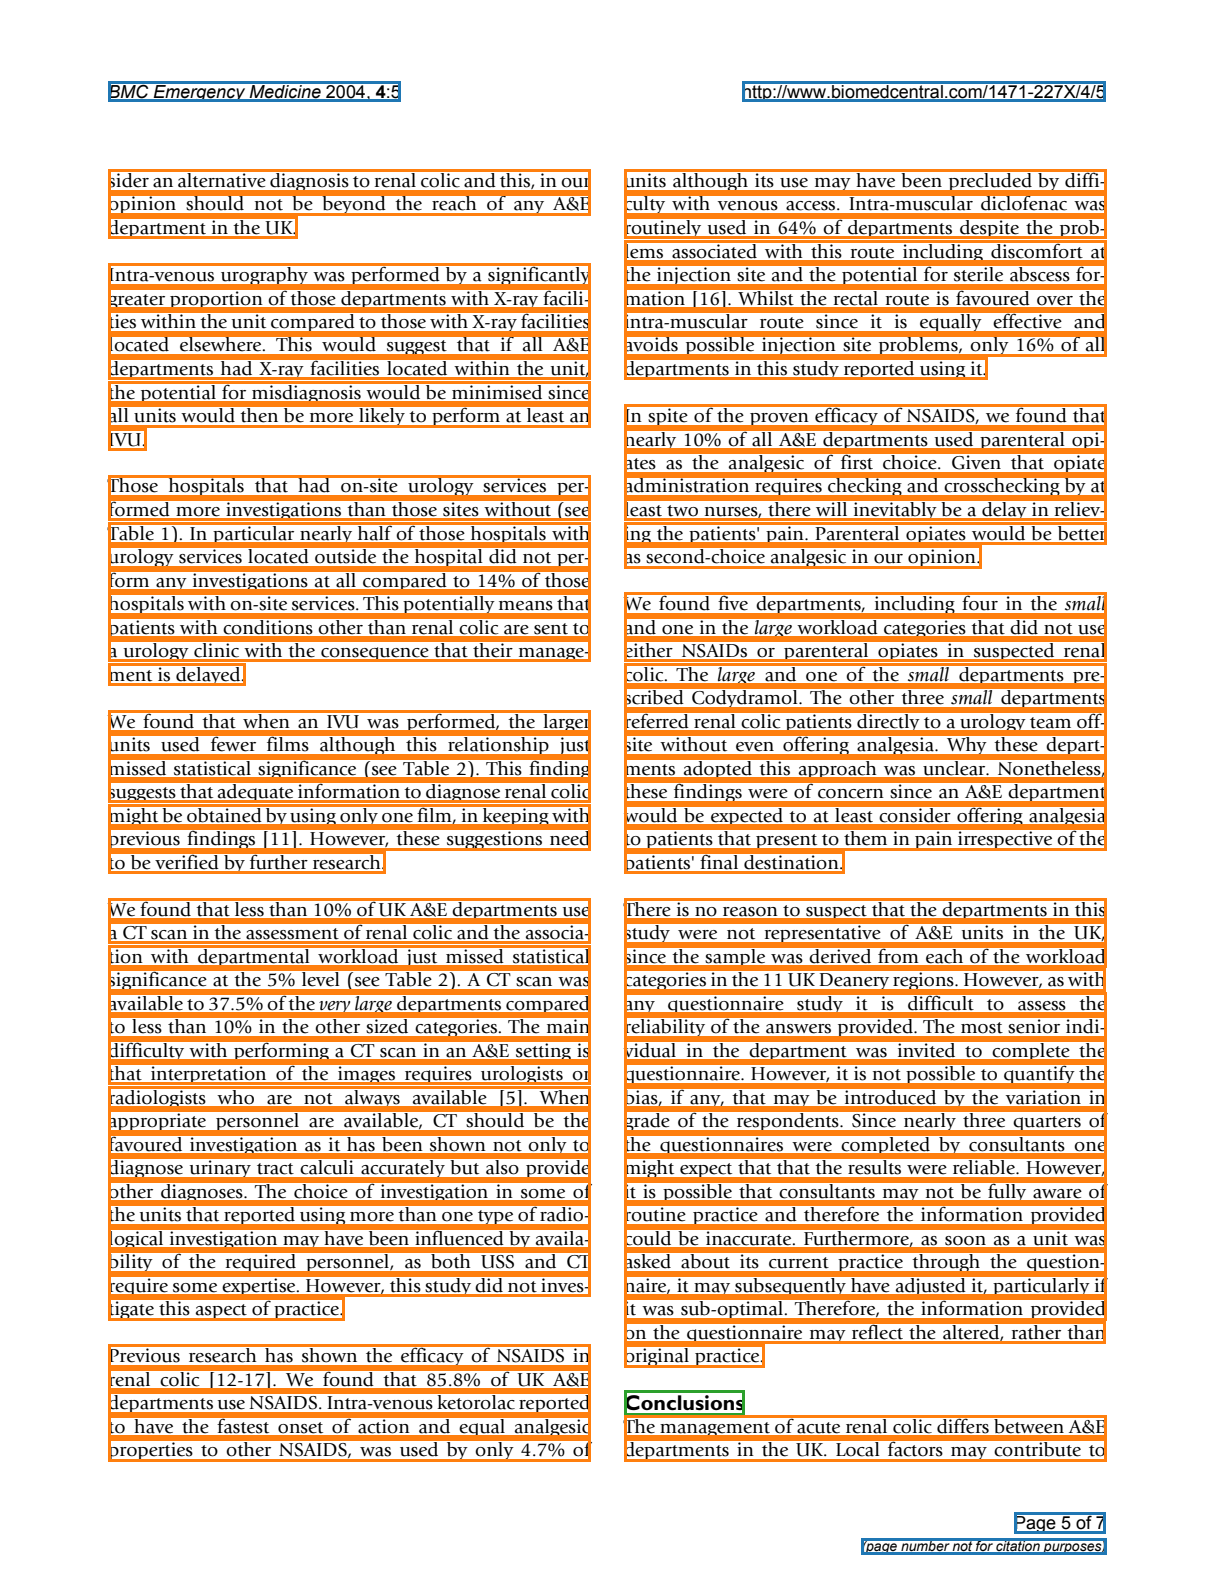

In [11]:
# Merging src_boxes(tboxes_k from PubLN) with lines(pdf.content from PdfMiner)
pages = [page for page in show_annotations(doc.content, doc.content_boxes)]
display(pages[doc._page_num])

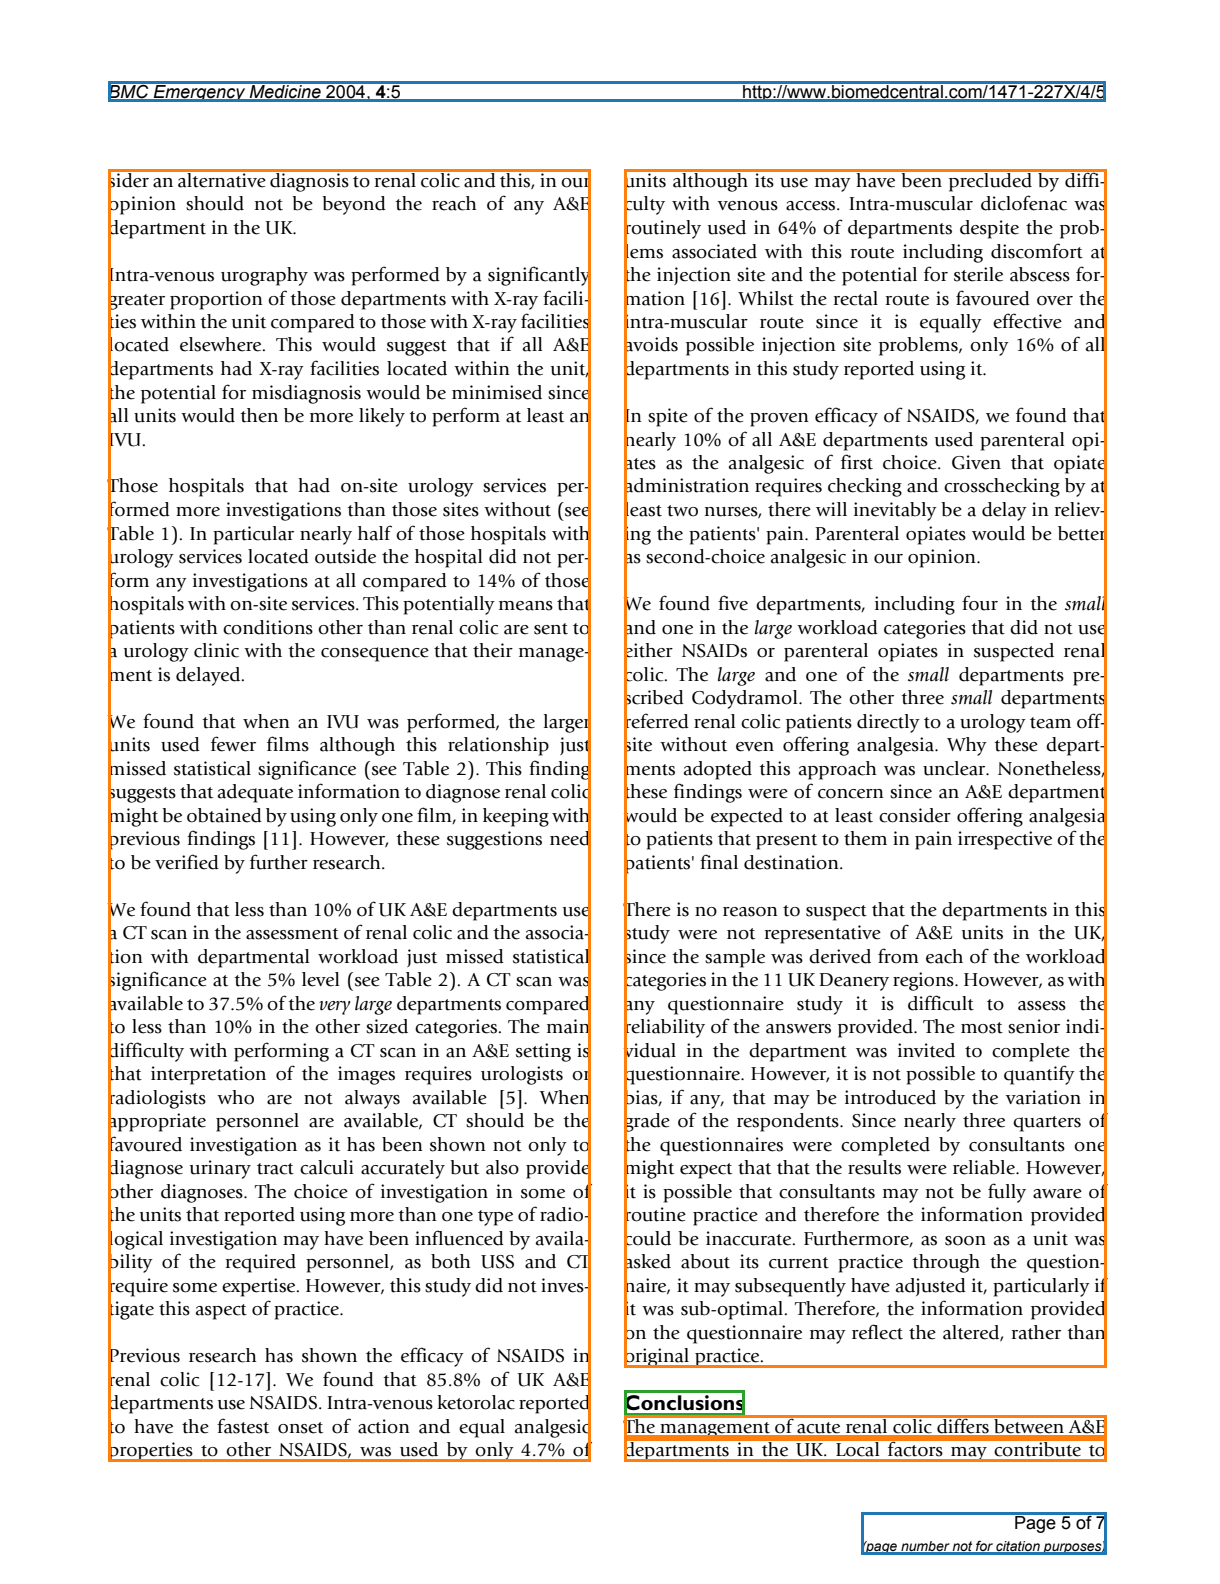

In [12]:
pages = [page for page in show_annotations(doc.content, merge_boxes(doc.content_boxes))]
display(pages[doc._page_num])


In [13]:
k = 2
box_k = doc.boxes_lines[k]
print(box_k.text)

print('\nBIOUL:')
for li in box_k.lines:
   print(li.bioul)
len(doc.boxes_lines)

text@@:
units although its use may have been precluded by diffi- culty with venous access. Intra-muscular diclofenac was routinely used in 64% of departments despite the prob- lems associated with this route including discomfort at the injection site and the potential for sterile abscess for- mation [16]. Whilst the rectal route is favoured over the intra-muscular route since it is equally effective and avoids possible injection site problems, only 16% of all departments in this study reported using it.

BIOUL:
B
I
I
I
I
I
I
I
L


13

In [14]:
box_k.lines[0]

TextBox(x0=0.5116059850473873, x1=0.9066318199282787, y0=0.10720667212900489, y1=0.12125894758436415, label='text', page_num=4, text='units although its use may have been precluded by diffi-', props=[], is_begin=None, is_last=None)

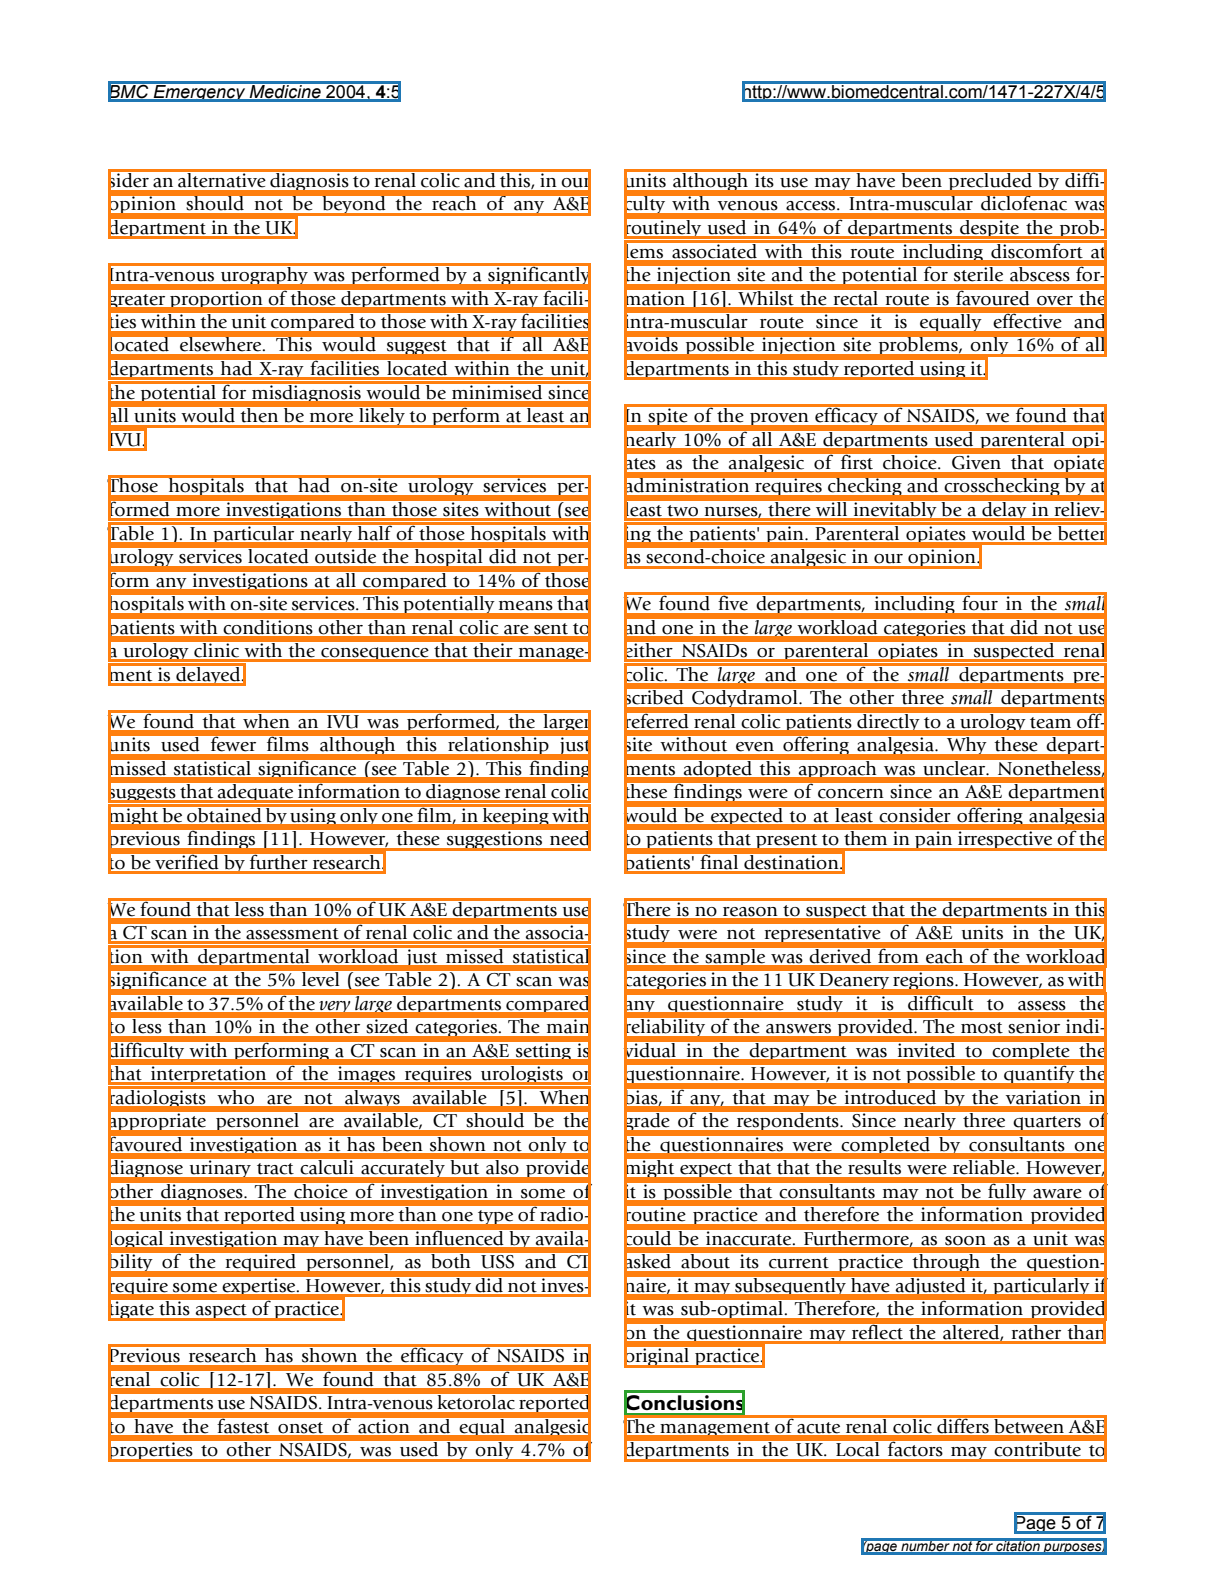

In [15]:
lines = []
[lines.extend(lns.lines) for lns in doc.boxes_lines]
pages = [page for page in show_annotations(doc.content, [li for li in lines])]
display(pages[doc._page_num])


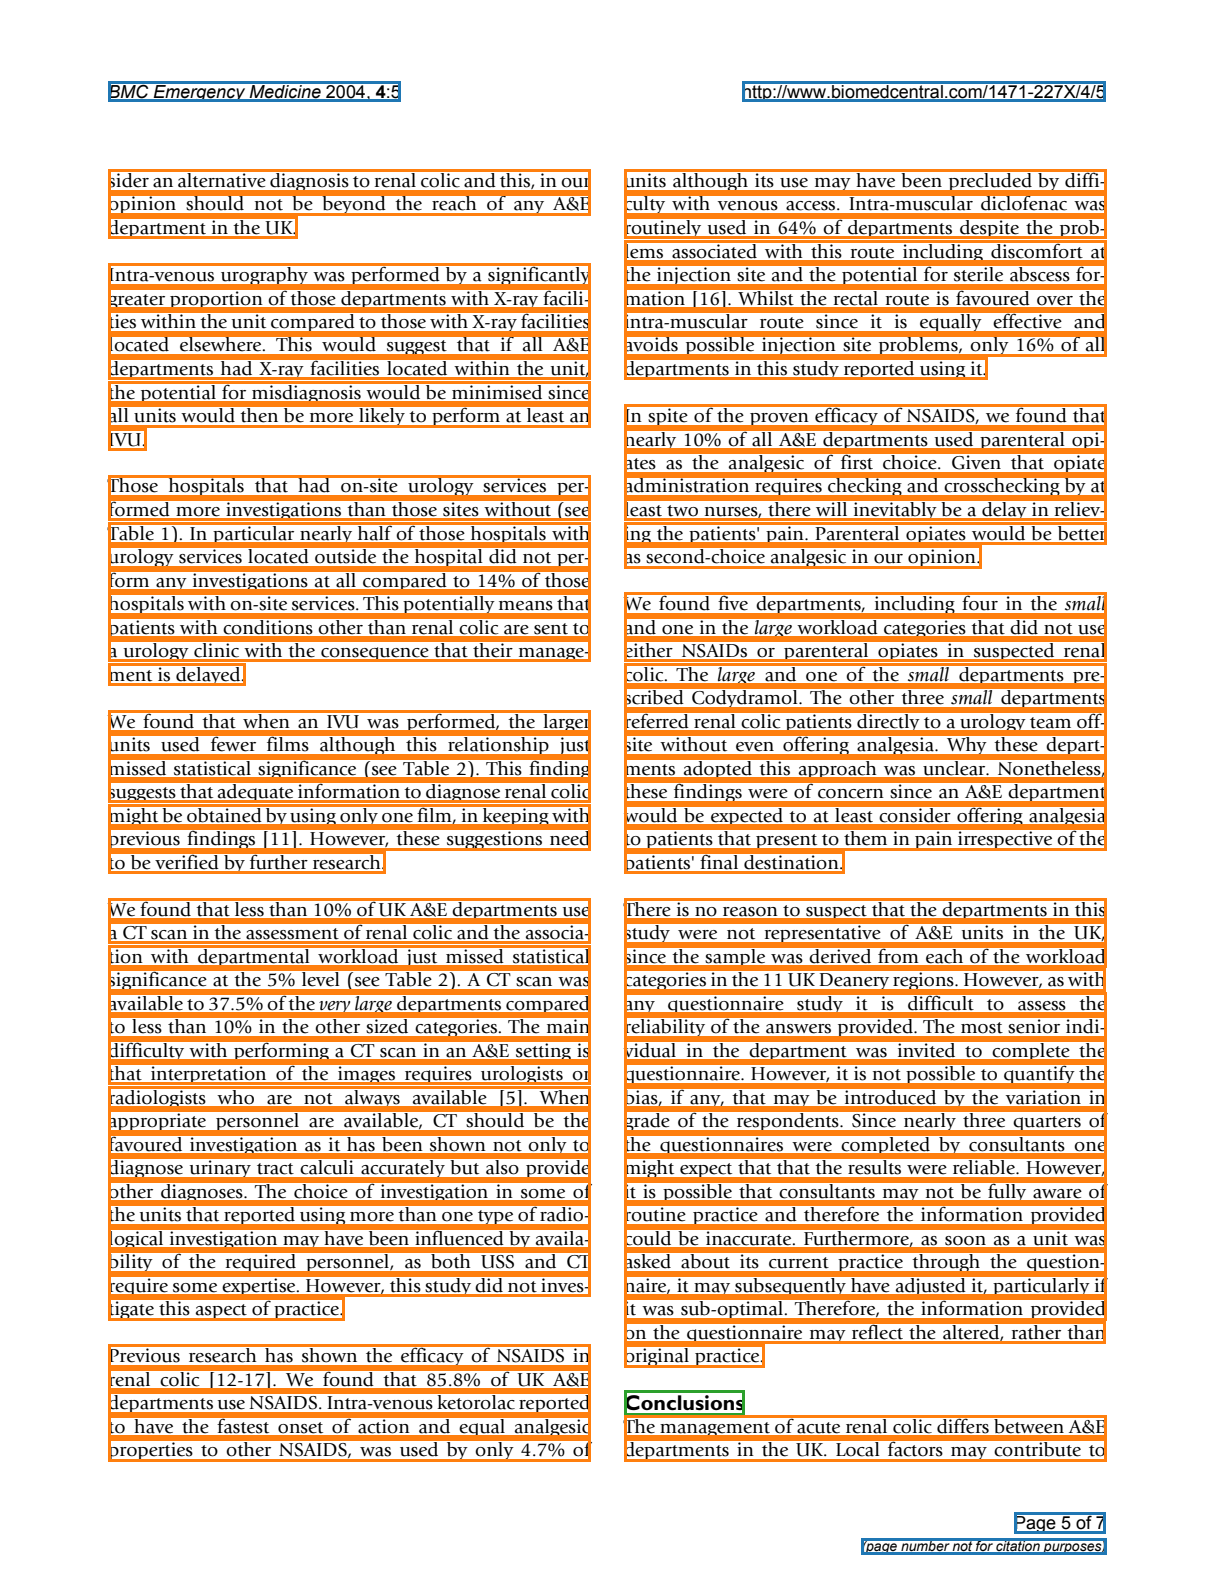

In [16]:
display(pages[doc._page_num])

## BIOUL is_begin, is_last

In [17]:
from edspdf.utils.alignment import align_box_labels_bioul

import numpy as np


@registry.adapter.register("edspdf-model.bl-segmentation-adapter")
def segmentation_adapter_bl(
    xmls_dir: str,
    dev_path: str = '../data/publaynet/dev.json',
    all_pdfs: bool = False,
    subset: Optional[int] = None,
    split_pages: bool = False,
) -> Callable[[Pipeline], Generator[PDFDoc, Any, None]]:
    xmls_dir = xmls_dir if xmls_dir[-1] == '/' else xmls_dir + '/'
    assert Path(dev_path).exists()
    assert Path(xmls_dir).exists()
    print('bioul')

    def adapt(model):
        count = 0
        
        with open(dev_path) as f:
            samples = json.load(f)
        
        # load xml files
        xmls_names = {} # {pmc = {xml_fname, pdf_fname}}
        for root, directories, files in os.walk(xmls_dir):
            for pmc in directories:
                fdir = xmls_dir + pmc
                for root2, directories2, files2 in os.walk(fdir):
                    xml_fname = None
                    pdfs_fnames = []
                    for file in files2:
                        if file.split('.')[-1] == 'nxml':
                            xml_fname = file
                        if file.split('.')[-1] == 'pdf':
                            pdfs_fnames.append(file)

                    if len(pdfs_fnames) == 0:
                        print(f'pmc {pmc} is not linked with any .pdf file in ==> {fdir}')
                        continue
                    if xml_fname is None:
                        print(f'pmc {pmc} is not linked with any .nxml file in ==> {fdir}')
                        continue
                    lenghts = [len(pf) for pf in pdfs_fnames]

                    i_min = np.argmin(lenghts)
                    xmls_names[pmc] = {'xml' :xml_fname, 'pdf': pdfs_fnames[i_min]}
            break
        # end load xml files
    
    
        if not all_pdfs: # only images in xmls_names
            samples_img = [
                sample_img
                for sample_img in samples['images']
                if sample_img['file_name'].split('_')[0] in xmls_names
            ]
            samples['images'] = samples_img
        # end only images in xmls_names


        # Index images
        images = {}
        for image in samples['images']:
            images[image['id']] = {
                'pmc_id': image['file_name'].split('_')[0], 
                'page_num': int(image['file_name'].split('_')[1].split('.')[0]), 
                'annotations': []
            }
        for ann in samples['annotations']:
            if all_pdfs:
                images[ann['image_id']]['annotations'].append(ann) # all
            elif ann['image_id'] in images: # with only images in xmls_names
                images[ann['image_id']]['annotations'].append(ann)
        # end index images
        
        
        
        # for each file
        for sample in samples['images']:
            if subset is not None and count > subset:
                return
            # boxes from PubLN
            w, h = sample['width'], sample['height']
            boxes = [
                {
                    'x0':       annotation["bbox"][0]/w,
                    'y0':       annotation["bbox"][1]/h,
                    'x1':       annotation["bbox"][0]/w + annotation["bbox"][2]/w,
                    'y1':       annotation["bbox"][1]/h + annotation["bbox"][3]/h,
                    'page_num': images[sample['id']]['page_num'],
                    'label':    annotation["category_id"]
                }
                for annotation in images[sample['id']]['annotations']
            ]
            
            
            # tboxes from extractor
            pmc_id = images[sample['id']]['pmc_id']
            xml_name = xmls_names[pmc_id]
            xml_path = xmls_dir + pmc_id + '/' + xml_name['xml']
            pdf_path = xmls_dir + pmc_id + '/' + xml_name['pdf']

            sample_content = Path(pdf_path).read_bytes()
            doc: PDFDoc = model.get_pipe("extractor")(sample_content) # doc = model(doc)
            # doc.content_lines = doc.content_boxes
            doc._page_num = images[sample['id']]['page_num']
            doc.id = pmc_id
            
            
            doc.content_boxes = [
                box_lines
                for box_lines in align_box_labels_bioul(
                    src_boxes=[
                        Box(
                            page_num= tboxe['page_num'],
                            x0= tboxe['x0'],
                            x1= tboxe['x1'],
                            y0= tboxe['y0'],
                            y1= tboxe['y1'],
                            label= samples['categories'][tboxe['label']-1]['name']
                        )
                        for tboxe in boxes
                    ],
                    dst_boxes=doc.content_boxes,
                    pollution_label='pollution',
                )
                if box_lines.text == "" or box_lines.label is not None
            ]
            for tb in doc.content_boxes:
                if not tb.label:
                    print('No label here')
            
            
            if split_pages:
                for page in doc.pages:
                    page = copy.deepcopy(page)
                    single_page_doc = page.doc
                    single_page_doc.pages = [page]
                    single_page_doc.content_boxes = [
                        line
                        for line in single_page_doc.content_boxes
                        if line.page_num == page.page_num
                    ]
                    if len(single_page_doc.content_boxes):
                        yield single_page_doc
                        count += 1
            else:
                yield doc
                count += 1

    return adapt


In [18]:
dev_path: str = dir + 'dev.json'
xmls_dir: str = dir + 'xmls/'

k = 0
for doc in tqdm(segmentation_adapter_bl(dev_path=dev_path, xmls_dir=xmls_dir)(model), mininterval=1):
  k -= 1
  
  if k < 0:
    break

  pass

# print(doc.content_boxes)

bioul


0it [00:01, ?it/s]


In [19]:
doc.content_boxes[0]

TextBox(x0=0.5116065353643698, x1=0.9066417256339652, y0=0.8934835568822995, y1=0.9075358227045849, label='B', page_num=4, text='The management of acute renal colic differs between A&E', props=[], is_begin=True, is_last=False)